# Import library

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Data Preparation

## Load the data

In [5]:
tfds.disable_progress_bar()

# Reserve 10% for validation and 10% for test
(train_ds, validation_ds, test_ds), info = tfds.load("colorectal_histology",
                                                     split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
                                                     as_supervised=True,
                                                     with_info=True)

print("Number of training examples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation examples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test examples: %d" % tf.data.experimental.cardinality(test_ds))

num_classes = info.features['label'].num_classes
print("Number of classes: %d" % num_classes)

original_image_size = info.features['image'].shape
print(f"Original image size: {original_image_size}")

# Get class names
Class_names = info.features["label"].names
print(f"class names are: {class_names}")

Number of training examples: 4000
Number of validation examples: 500
Number of test examples: 500
Number of classes: 8
Original image size: (150, 150, 3)
class names are: ['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']


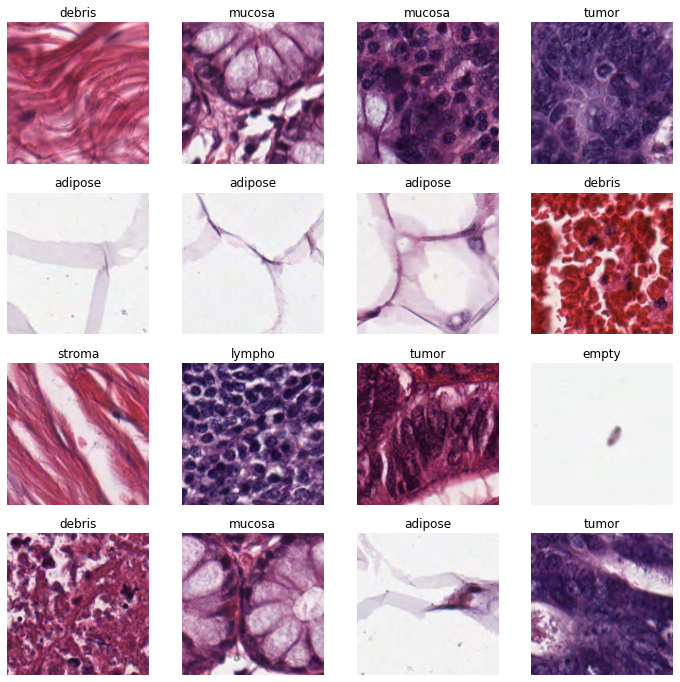

In [ ]:
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(train_ds.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(class_names[int(label)])
    plt.axis("off")

## Standardizing the data

In [ ]:
# Resizing the images
img_size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))

In [ ]:
# Batch, cache, and prefetch the data
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=5)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=5)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=5)

## Creating random rata augmentation

In [ ]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name ="data_augmentation")

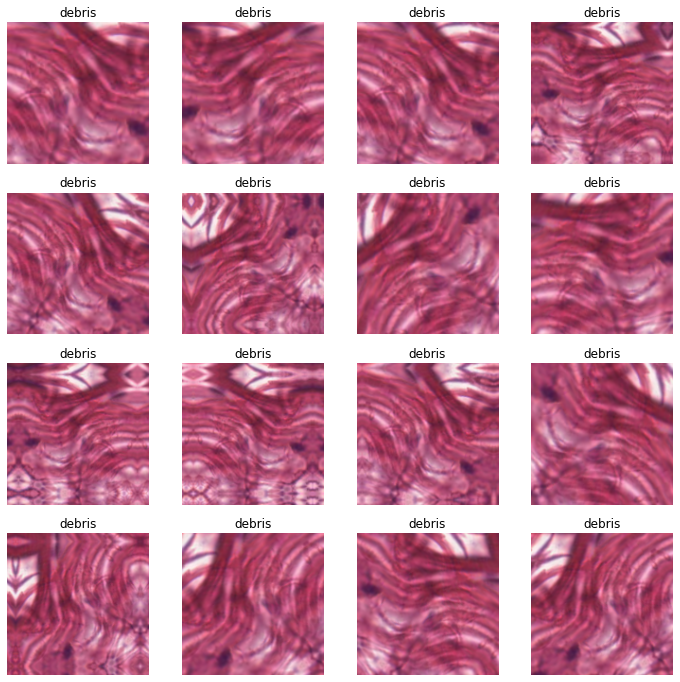

In [ ]:
# Visualizing the 1st image of the 1st batch after 16 random augmentation
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    image = images[0]
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        aug_img = data_augmentation(tf.expand_dims(image, 0), training=True)
        plt.imshow(tf.squeeze(aug_img).numpy().astype("int32"))
        plt.title(class_names[int(labels[0])])
        plt.axis("off")

# Build a model

Using ResNet50V2 model, pretrained on the ImageNet dataset, as base model.

Reference: [Identity Mappings in Deep Residual Networks] (https://arxiv.org/abs/1603.05027) (CVPR 2016)

## Feature Extraction

In [ ]:
# Setup input shape and base model
input_shape = img_size + (3, )
base_model = keras.applications.ResNet50V2(weights="imagenet",
                                           input_shape=input_shape,
                                           include_top=False)
# Freeze the base_model
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=input_shape, name="input_layer")

# Apply random data augmentation
x = data_augmentation(inputs)  

# Scaling input to a range of (-1., +1.) from (0, 255) 
x = keras.layers.Rescaling(scale=1/127.5, offset=-1)(x)

# Running the base_model in inference mode so that batchnorm statistics don't get updated even for fine-tuning.
x = base_model(x, training=False)

# Convert outputs of the base model to vectors
x = keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer
outputs = keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 150, 150, 3)      0         
 al)                                                             
                                                                 
 rescaling_20 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 8)                 163

In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_feature_extraction = model.fit(train_ds,
                                       epochs=10,
                                       validation_data=validation_ds)

Epoch 1/10
125/125 [==============================] - 12s 76ms/step - loss: 0.7293 - accuracy: 0.7567 - val_loss: 0.4345 - val_accuracy: 0.8580
Epoch 2/10
125/125 [==============================] - 8s 63ms/step - loss: 0.4336 - accuracy: 0.8465 - val_loss: 0.3546 - val_accuracy: 0.8780
Epoch 3/10
125/125 [==============================] - 8s 62ms/step - loss: 0.3707 - accuracy: 0.8700 - val_loss: 0.3410 - val_accuracy: 0.8880
Epoch 4/10
125/125 [==============================] - 8s 62ms/step - loss: 0.3496 - accuracy: 0.8813 - val_loss: 0.3264 - val_accuracy: 0.8980
Epoch 5/10
125/125 [==============================] - 8s 61ms/step - loss: 0.3332 - accuracy: 0.8830 - val_loss: 0.3418 - val_accuracy: 0.8880
Epoch 6/10
125/125 [==============================] - 8s 61ms/step - loss: 0.3142 - accuracy: 0.8923 - val_loss: 0.2980 - val_accuracy: 0.9040
Epoch 7/10
125/125 [==============================] - 8s 62ms/step - loss: 0.2991 - accuracy: 0.8963 - val_loss: 0.2969 - val_accuracy: 0.906

## Fine-tuning

In [ ]:
# Unfreeze the entire base model
base_model.trainable = True

# Freeze all layers except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 150, 150, 3)      0         
 al)                                                             
                                                                 
 rescaling_20 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 8)                 163

In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["accuracy"])

# Fit the model
history_fine_tuning = model.fit(train_ds,
                                epochs=10,
                                validation_data=validation_ds)

Epoch 1/10
125/125 [==============================] - 12s 74ms/step - loss: 0.1474 - accuracy: 0.9445 - val_loss: 0.2283 - val_accuracy: 0.9180
Epoch 2/10
125/125 [==============================] - 8s 68ms/step - loss: 0.1284 - accuracy: 0.9503 - val_loss: 0.2210 - val_accuracy: 0.9280
Epoch 3/10
125/125 [==============================] - 8s 68ms/step - loss: 0.1328 - accuracy: 0.9520 - val_loss: 0.2201 - val_accuracy: 0.9300
Epoch 4/10
125/125 [==============================] - 8s 67ms/step - loss: 0.1257 - accuracy: 0.9560 - val_loss: 0.2213 - val_accuracy: 0.9320
Epoch 5/10
125/125 [==============================] - 8s 67ms/step - loss: 0.1247 - accuracy: 0.9582 - val_loss: 0.2238 - val_accuracy: 0.9320
Epoch 6/10
125/125 [==============================] - 8s 66ms/step - loss: 0.1151 - accuracy: 0.9597 - val_loss: 0.2256 - val_accuracy: 0.9260
Epoch 7/10
125/125 [==============================] - 8s 66ms/step - loss: 0.1226 - accuracy: 0.9582 - val_loss: 0.2145 - val_accuracy: 0.932

# Evaluation

## Loss curves

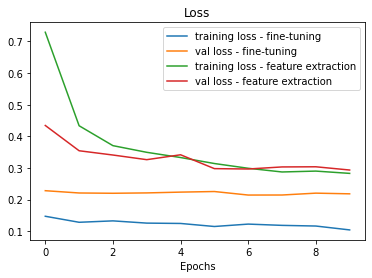

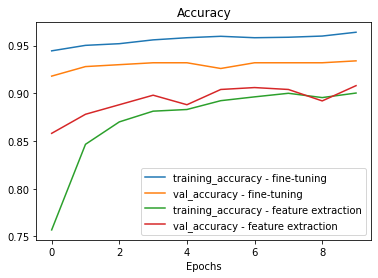

In [ ]:
# Comparing accuracy and loss curves for training and validation sets for feature extraction and fine-tuning 
loss_fn = history_fine_tuning.history['loss']
val_loss_fn = history_fine_tuning.history['val_loss']
accuracy_fn = history_fine_tuning.history['accuracy']
val_accuracy_fn = history_fine_tuning.history['val_accuracy']

loss_fe = history_feature_extraction.history['loss']
val_loss_fe = history_feature_extraction.history['val_loss']
accuracy_fe = history_feature_extraction.history['accuracy']
val_accuracy_fe = history_feature_extraction.history['val_accuracy']

epochs = range(len(history_fine_tuning.history['loss']))

# Plot loss
plt.figure()
plt.plot(epochs, loss_fn, label='training loss - fine-tuning')
plt.plot(epochs, val_loss_fn, label='val loss - fine-tuning')
plt.plot(epochs, loss_fe, label='training loss - feature extraction')
plt.plot(epochs, val_loss_fe, label='val loss - feature extraction')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend();

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy_fn, label='training_accuracy - fine-tuning')
plt.plot(epochs, val_accuracy_fn, label='val_accuracy - fine-tuning')
plt.plot(epochs, accuracy_fe, label='training_accuracy - feature extraction')
plt.plot(epochs, val_accuracy_fe, label='val_accuracy - feature extraction')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

## Evaluate on test data

In [ ]:
# Evaluate the model on the test data
print("Evaluation on Test data \n")
loss, accuracy = model.evaluate(test_ds, batch_size=32)
print(f"\nModel loss on test set: {(loss):.2f}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

Evaluation on Test data 

16/16 [==============================] - 1s 53ms/step - loss: 0.2008 - accuracy: 0.9300

Model loss on test set: 0.20
Model accuracy on test set: 93.00%


## Confusion matrix & classification report

In [ ]:
# Model prediction for test data
pred = model.predict(test_ds)

# Match the prediction class to the highest prediction probability
y_pred = [pred[i].argmax() for i in range(len(pred))]
y_pred_class = [class_names[y_pred[i]] for i in range(len(y_pred))]

# Extract the truth ground label and match to class_names 
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_class = [class_names[y_true[i]] for i in range(len(y_true))]

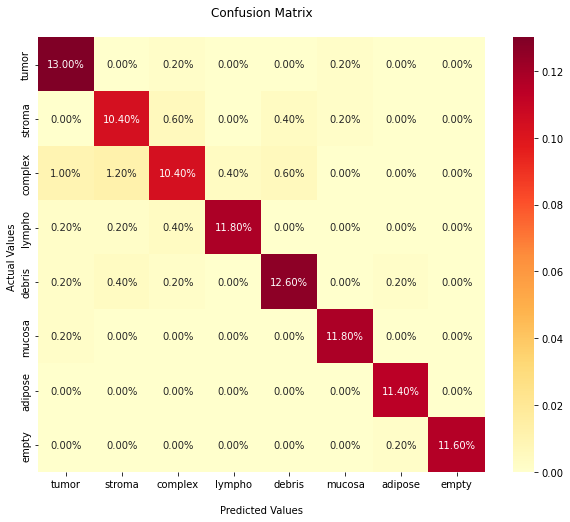

In [ ]:
# Plot confusion matrix from predictions
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='YlOrRd')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()

In [ ]:
# Classification report
print(classification_report(y_true_class, y_pred_class, digits=3))

              precision    recall  f1-score   support

     adipose      0.966     1.000     0.983        57
     complex      0.881     0.765     0.819        68
      debris      0.926     0.926     0.926        68
       empty      1.000     0.983     0.991        59
      lympho      0.967     0.937     0.952        63
      mucosa      0.967     0.983     0.975        60
      stroma      0.852     0.897     0.874        58
       tumor      0.890     0.970     0.929        67

    accuracy                          0.930       500
   macro avg      0.931     0.933     0.931       500
weighted avg      0.930     0.930     0.929       500



# Summary

By training the top 10 layers of the base model, ResNet50V2, an accuracy of  93% is achieved on validation and test sets.